In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import minmax_scale as mms
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
def load_data(path,name):
    csv_path = os.path.join(path, name)
    return pd.read_csv(csv_path)

In [5]:
path = "C:/Users/DanielaFe7/Desktop/Maestrado/Redes Neurais/RedesNeurais"
name = "winequality-red.csv"
data = load_data(path,name)
print("Loading wine dataset ...")
#data.info()

Loading wine dataset ...


# Pre-processing Data Set

In [6]:
#Convert Categorical Output to One Hot Vector: [100-010-001]
print("Convert Categorical Output to One Hot Vector")
Y = data["category"]
Y = Y.values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
enc.fit(Y)
Y = enc.transform(Y).toarray()

Convert Categorical Output to One Hot Vector


In [7]:
X = data
X = X.drop("Unnamed: 0", axis = 1)
X = X.drop("category", axis = 1)
print("Preparing inputs droping Labels and droping indexs")
X.head()

Preparing inputs droping Labels and droping indexs


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)
print("Traind and Test datasets Stratify Splitting")

Traind and Test datasets Stratify Splitting


In [9]:
print("Train and Test Shapes after Splitting")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Train and Test Shapes after Scalling : Values between 0 and 1")
x_train = mms(x_train)
x_test = mms(x_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
#x_train

Train and Test Shapes after Splitting
(1199, 11)
(400, 11)
(1199, 3)
(400, 3)
Train and Test Shapes after Scalling : Values between 0 and 1
(1199, 11)
(400, 11)
(1199, 3)
(400, 3)


# NN L-Layer

In [10]:
def sigmoid(Z):
    S = 1 / (1 + np.exp(-Z))
    return S,Z

In [11]:
def derivade_sigmoid(z):
    gz,z = sigmoid(z) 
    return gz * (1-gz);

In [12]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network, (including input layer)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.normal(0, 1, (layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.random.random((layer_dims[l], 1))
      
    return parameters

In [13]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
        
    return v

# Forward Propagation in L - Layers

In [14]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

In [15]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache) #linear_cahce: A_prev,Wi,bi - activation_cache: Zi
    return A, cache

In [16]:
def L_model_forward(X,Y,parameters,pred=False):
    caches = []
    A = X                                     #(input size, number of examples)
    L = len(parameters) // 2                  # number of layers in the neural network (not input layer including)
    
    # Implement [LINEAR -> SIGMOID]*(L-1). To L-1 Layers
    for l in range(1, L):
        A_prev = A 
        W=parameters['W' + str(l)]
        b=parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "sigmoid")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Last layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    # Predicction
    if pred:
        # The max value is 1 , else 0
        AL_temp = AL.T
        Y_prediction = np.zeros_like(AL_temp)
        Y_prediction[np.arange(len(AL_temp)), AL_temp.argmax(1)] = 1
        Y_prediction = Y_prediction.T
        return Y_prediction
    return AL, caches

In [17]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (- 1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * (np.log(1 - AL)))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

# Backward Propagation in L - Layers

In [18]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [19]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ = dA * derivade_sigmoid(activation_cache) # activation_cache = Z ; dA = np.dot(W.T,dZ) excep the first dA
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)    
    return dA_prev, dW, db

In [20]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers (not input layer including)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL =- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, 
                                                                                                  current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (SIGMOID -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads

# Update Parameters

In [35]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network (not input layer including)

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

# Update Parameters with Momentum

In [38]:
def update_parameters_with_momentum(parameters, grads, v, learning_rate, beta):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    
    # Momentum update for each parameter
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
    return parameters, v

# L - layer model

In [59]:
def L_layer_model(X, Y, X_test, Y_test, layers_dims, learning_rate, num_iterations, print_cost=False):
    np.random.seed(1)
    costs = []                         
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    #Velocity initialization.
    v = initialize_velocity(parameters)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> SIGMOID]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,Y,parameters,pred=False)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters. #Esto tem que quedar comentado si vc vai usar com Momemtum
        #parameters = update_parameters(parameters, grads, learning_rate)
        
        # Update parameters with Momentum.
        parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate, beta = 0.9)
                
        # Print the cost every 100 training example
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 500 == 0:
            costs.append(cost)
            
    # Train Predicction
    Y_prediction =  L_model_forward(X,Y,parameters,pred=True)
    print("------------------")
    print("Train Prediccion:")
    print(Y_prediction.shape)
    print(Y_prediction)
    print("Train Accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y)) * 100))
    print("Train F1 Score: ",f1_score(Y, Y_prediction, average='macro')*100)  
    
    # Test Predicction
    print("------------------")
    Y_prediction =  L_model_forward(X_test,Y_test,parameters,pred=True)
    print("Test Prediccion:")
    print(Y_prediction.shape)
    print(Y_prediction)
    print("Test Accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y_test)) * 100))
    print("Test F1 Score: ",f1_score(Y_test, Y_prediction, average='macro')*100)  



    if np.array_equal(Y,Y_prediction):
        print("Success Prediction")
    else:
        print("Un - success Prediction")
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
            
    
    return parameters

(11, 1199)
(3, 1199)
Cost after iteration 0: 1.961247
Cost after iteration 500: 0.845918
Cost after iteration 1000: 0.815891
Cost after iteration 1500: 0.805659
Cost after iteration 2000: 0.798088
Cost after iteration 2500: 0.790639
Cost after iteration 3000: 0.782327
Cost after iteration 3500: 0.772807
Cost after iteration 4000: 0.762725
Cost after iteration 4500: 0.752688
Cost after iteration 5000: 0.742166
Cost after iteration 5500: 0.730470
Cost after iteration 6000: 0.718244
Cost after iteration 6500: 0.707193
Cost after iteration 7000: 0.698066
Cost after iteration 7500: 0.690675
Cost after iteration 8000: 0.684602
Cost after iteration 8500: 0.679359
Cost after iteration 9000: 0.674486
Cost after iteration 9500: 0.669678
------------------
Train Prediccion:
(3, 1199)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 1.]]
Train Accuracy: 90.99249374478732 %
Train F1 Score:  86.48874061718098
------------------
Test Prediccion:
(3, 400)
[[0. 0. 0. ... 0. 0. 0.]

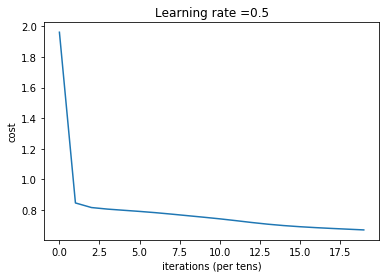

In [58]:
X, Y = x_train.T , y_train.T
X_test, Y_test = x_test.T, y_test.T 
#print(X)
#print(Y)
print(X.shape)
print(Y.shape)
layers_dims = [11, 9, 7, 5 ,3] #  2-layer model
parameters = L_layer_model(X, Y, X_test, Y_test,layers_dims, learning_rate = 0.5, num_iterations = 10000, print_cost = True)